# 08_plot_ILC_figure

In [1]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne_bids
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
from scipy import signal, fftpack

In [24]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]
labels = ['LC', 'LF', 'LO', 'LP', 'LT', 'RC', 'RF', 'RO', 'RP', 'RT']

# set path
pre_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
post_root = pjoin(pre_root, 'derivatives', 'preproc_meg-mne_mri-fmriprep')
results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'

In [22]:
def get_picks(data):
    # get valid channels
    ch_name_picks = mne.pick_channels_regexp(data.ch_names, regexp='M[LRZ]...-4503')
    type_picks = mne.pick_types(data.info, meg=True)
    picks= np.intersect1d(ch_name_picks, type_picks)
    return picks

def ch_ilc2roi_ilc(ch_corr, ch_name):
    
    labels = ['LC', 'LF', 'LO', 'LP', 'LT', 'RC', 'RF', 'RO', 'RP', 'RT']
    ch_labels = dict()
    for label in labels:
        reg = re.compile('M'+label+'.*')
        tmp_chs = list(filter(reg.match, ch_name))
        ch_labels[label] = [ch_name.index(x) for x in tmp_chs]

    roi_corr = np.zeros((len(labels), len(labels)))

    for i, (roi_x, ch_idx_x) in enumerate(ch_labels.items()):
        for j, (roi_y, ch_idx_y) in enumerate(ch_labels.items()):
            tmp = ch_corr.take(ch_idx_x, axis=0)
            roi_val = tmp.take(ch_idx_y, axis=1)
            roi_corr[i][j] = np.mean(roi_val)
    return roi_corr

def plot_lobecorr_rdm(lobe_corr, fig, ax, label):
    
    c = ax.pcolor(lobe_corr)
    fig.colorbar(c, ax=ax)
    
    ax.set_xticks(np.arange(0.5, len(label), 1))
    ax.set_yticks(np.arange(0.5, len(label), 1))
    ax.set_xticklabels(label)
    ax.set_yticklabels(label)
    ax.set_aspect('equal', adjustable='box')

def plot_lobecorr_box(lobe_corr, ax):
    
    same_hemi_same_lobe = []
    for i in np.arange(lobe_corr.shape[0]):
        same_hemi_same_lobe.append(lobe_corr[i, i])
        
    diff_hemi_same_lobe = []
    for i in np.arange(5):
        diff_hemi_same_lobe.append(lobe_corr[i, 5+i])
        diff_hemi_same_lobe.append(lobe_corr[5+i, i])
        
    same_hemi_diff_lobe = np.array([])
    for i in [0,5]:
        same_hemi_diff_lobe = np.append(same_hemi_diff_lobe, (lobe_corr[i:i+5, i:i+5].ravel()[np.flatnonzero(np.tril(lobe_corr[i:i+5, i:i+5], k=-1))]))
        same_hemi_diff_lobe = np.append(same_hemi_diff_lobe,(lobe_corr[i:i+5, i:i+5].ravel()[np.flatnonzero(np.triu(lobe_corr[i:i+5, i:i+5], k=1))]))
    diff_hemi_diff_lobe = np.array([])
    for i in [0,5]:
        diff_hemi_diff_lobe = np.append(diff_hemi_diff_lobe, (lobe_corr[i:i+5, 5-i:10-i].ravel()[np.flatnonzero(np.tril(lobe_corr[i:i+5, 5-i:10-i], k=-1))]))
        diff_hemi_diff_lobe = np.append(diff_hemi_diff_lobe,(lobe_corr[i:i+5, 5-i:10-i].ravel()[np.flatnonzero(np.triu(lobe_corr[i:i+5, 5-i:10-i], k=1))]))
    
    ax.boxplot(same_hemi_same_lobe, positions=[1], whis=0.95)
    ax.boxplot(same_hemi_diff_lobe, positions=[3], whis=0.95)
    ax.boxplot(diff_hemi_same_lobe, positions=[5], whis=0.95)
    ax.boxplot(diff_hemi_diff_lobe, positions=[7], whis=0.95)
    
    ax.set_xticks([1,3,5,7])
    ax.set_xticklabels(['s_hem_s_lobe', 's_hem_d_lobe', 'd_hem_s_lobe', 'd_hem_d_lobe'])
    ax.set_ylabel('corr coef')
    
    x = [1, 3, 5, 7]
    y = [np.array(same_hemi_same_lobe), same_hemi_diff_lobe, np.array(diff_hemi_same_lobe), diff_hemi_diff_lobe]
    for xs, val in zip(x, y):
        xx = np.ones(val.shape)*xs
        ax.scatter(xx, val, alpha=0.4)
        

In [17]:
# load data
ilc = pd.read_pickle(pjoin(results_pth, 'ilc.pickle'))

In [20]:
sub_path = BIDSPath(subject='01', run='01', task='movie', session='movie', root='/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids')
raw_sub = mne_bids.read_raw_bids(sub_path)
picks = get_picks(raw_sub)

ch_name = []
for idx in picks:
    ch_name.append(raw_sub.ch_names[idx])

ds directory : /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds
    res4 data read.
    hc data read.
    Separate EEG position data file read.
    Quaternion matching (desired vs. transformed):
       4.65   74.88    0.00 mm <->    4.65   74.88    0.00 mm (orig :  -65.68   46.24 -249.17 mm) diff =    0.000 mm
      -4.65  -74.88    0.00 mm <->   -4.65  -74.88    0.00 mm (orig :   42.00  -58.24 -250.44 mm) diff =    0.000 mm
      92.94    0.00    0.00 mm <->   92.94   -0.00    0.00 mm (orig :   46.46   62.07 -225.18 mm) diff =    0.000 mm
    Coordinate transformations established.
    Polhemus data for 3 HPI coils added
    Device coordinate locations for 3 HPI coils added
    Measurement info composed.
Finding samples for /nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids/sub-01/ses-movie/meg/sub-01_ses-movie_task-movie_run-01_meg.ds/sub-01_ses-movie_task-movie_run-01_meg.meg4: 
    System clock channel is availabl

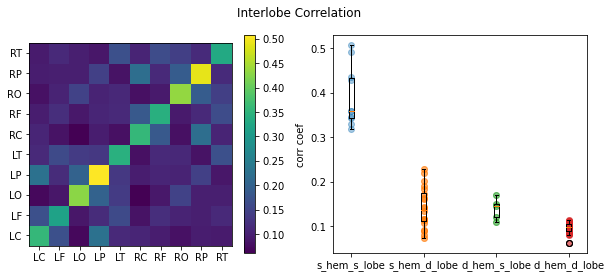

In [25]:
lobe_corr = np.zeros((10, 10))
for sub in sub_list:
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list
    
    for run in run_ls: 
        lobe_corr += ch_ilc2roi_ilc(ilc[sub][run], ch_name)
lobe_corr /= (len(sub_list)*len(run_list)+1)

fig, axes = plt.subplots(1, 2, figsize=(10,4))
plt.suptitle('Interlobe Correlation')
plot_lobecorr_rdm(lobe_corr, fig, axes[0], labels)
plot_lobecorr_box(lobe_corr, axes[1])